In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import glob
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
SENSOR_DIR = r"C:\\DumbStuff\\epf study\\Meta-Elasto\\els\\meta\\Elastography_rawdata\\oldcode"

def build_cv_dataset():
    # Load and Label Timepoints
    df_pre = pd.read_csv("label-pre.csv"); df_pre['Time'] = 'PRE'
    df_post = pd.read_csv("label-post.csv"); df_post['Time'] = 'POST'
    df_fup = pd.read_csv("label-fup.csv"); df_fup['Time'] = 'FOLLOWUP'
    df_clinical = pd.concat([df_pre, df_post, df_fup], axis=0, ignore_index=True)

    # --- CALCULATE CARDIOVASCULAR RISK SCORE (0 to 4) ---
    # We focus on mechanical/vascular stress (No Glucose)
    def calculate_cv_score(row):
        score = 0
        try:
            # 1. Hypertension
            if float(row['Blood_Pressure']) > 130: score += 1
            # 2. High Triglycerides (Vascular plaque risk)
            if float(row['Triglycerides']) > 150: score += 1
            # 3. Low HDL (Good cholesterol) - Sex specific
            if (row['Sex'] == 0 and float(row['HDL_Cholestrol']) < 40) or \
               (row['Sex'] == 1 and float(row['HDL_Cholestrol']) < 50):
                score += 1
            # 4. Central Obesity (Cardiac strain) - Sex specific
            if (row['Sex'] == 0 and float(row['Waist_Circum_mean']) > 94) or \
               (row['Sex'] == 1 and float(row['Waist_Circum_mean']) > 80):
                score += 1
        except: pass 
        return score

    df_clinical['CV_Risk_Score'] = df_clinical.apply(calculate_cv_score, axis=1)

    # Merge with mapping table
    df_mapping = pd.read_excel("meta/measured_with_elastograph_patients.xlsx")
    df_mapping.columns = df_mapping.columns.str.strip()
    df_master = pd.merge(df_mapping, df_clinical, on=['ID', 'Time'], how='inner')

    # Data Type Safety
    meta_cols = ['Sex', 'Age', 'Waist_Circum_mean']
    for col in meta_cols:
        df_master[col] = pd.to_numeric(df_master[col], errors='coerce')
    
    df_master = df_master.dropna(subset=meta_cols + ['CV_Risk_Score'])
    
    # Scale demographics
    scaler = StandardScaler()
    df_master[meta_cols] = scaler.fit_transform(df_master[meta_cols])
    
    return df_master, meta_cols, scaler

df_master, meta_cols, clinical_scaler = build_cv_dataset()
print(f"CV Dataset Built. Total samples: {len(df_master)}")

CV Dataset Built. Total samples: 135


In [6]:
class CVEncoderDataset(Dataset):
    def __init__(self, dataframe, sensor_dir, max_len=2000):
        self.df = dataframe
        self.sensor_dir = sensor_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p_num_str = str(int(row['N_PACIENT'])).zfill(4)
        
        files = glob.glob(os.path.join(self.sensor_dir, f"in_test_{p_num_str}_*.csv"))
        if not files: return None
        
        df_sig = pd.read_csv(files[0])
        # Extract all 18 channels (F1 to F18)
        signal = df_sig.filter(regex=r'^F\d+').fillna(0).values.T
        
        if signal.shape[1] > self.max_len:
            signal = signal[:, :self.max_len]
        else:
            signal = np.pad(signal, ((0,0), (0, self.max_len - signal.shape[1])), 'constant')
            
        # Z-score normalization per channel
        for i in range(signal.shape[0]):
            std = np.std(signal[i, :]) + 1e-8
            signal[i, :] = (signal[i, :] - np.mean(signal[i, :])) / std
            
        meta = row[meta_cols].values.astype(np.float32)
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(meta, dtype=torch.float32), row['CV_Risk_Score']

In [7]:
class MultiModalEncoder(nn.Module):
    def __init__(self):
        super(MultiModalEncoder, self).__init__()
        # Signal Branch: 18 Channels
        self.cnn = nn.Sequential(
            nn.Conv1d(18, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        # Clinical Branch
        self.mlp = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

    def forward(self, signal, meta):
        s = self.cnn(signal).squeeze(-1)
        m = self.mlp(meta)
        return torch.cat((s, m), dim=1) # Fingerprint size: 80

In [8]:
loader = DataLoader(CVEncoderDataset(df_master, SENSOR_DIR), batch_size=1, shuffle=False)
encoder = MultiModalEncoder()
encoder.eval()

latent_vectors = []
cv_scores = []

print("Extracting Cardiovascular Fingerprints...")
with torch.no_grad():
    for item in loader:
        if item is None: continue
        sig, meta, score = item
        feat = encoder(sig, meta)
        latent_vectors.append(feat.numpy().flatten())
        cv_scores.append(score.item())

X_latent = np.array(latent_vectors)

# K-Means Clustering
# We use 2 clusters: "Low CV Risk" vs "High CV Risk"
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_latent)

Extracting Cardiovascular Fingerprints...


In [9]:
y_cv_truth = [1 if s >= 2 else 0 for s in cv_scores]

# Map AI clusters to Risk
df_eval = pd.DataFrame({'Cluster': clusters, 'Actual_Score': cv_scores, 'Truth': y_cv_truth})
high_risk_cluster = df_eval.groupby('Cluster')['Actual_Score'].mean().idxmax()

y_ai_pred = [1 if c == high_risk_cluster else 0 for c in clusters]

print(f"\n--- Cardiovascular Accuracy: {accuracy_score(y_cv_truth, y_ai_pred)*100:.2f}% ---")
print(classification_report(y_cv_truth, y_ai_pred, target_names=['Low CV Risk', 'High CV Risk']))


--- Cardiovascular Accuracy: 54.81% ---
              precision    recall  f1-score   support

 Low CV Risk       0.62      0.58      0.60        79
High CV Risk       0.46      0.50      0.48        56

    accuracy                           0.55       135
   macro avg       0.54      0.54      0.54       135
weighted avg       0.55      0.55      0.55       135



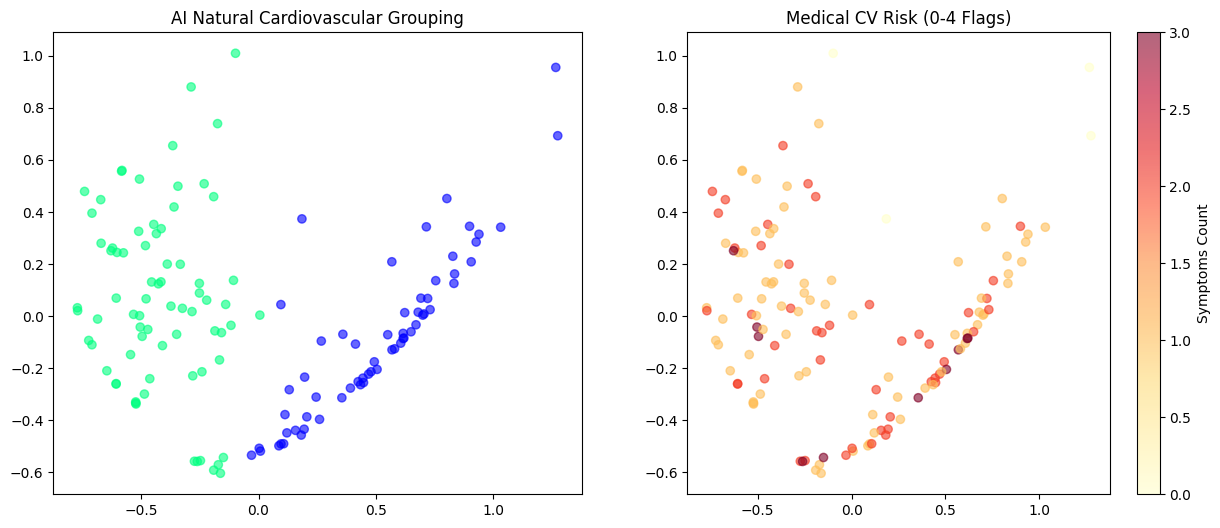

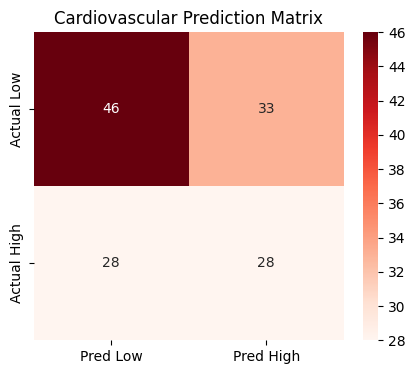

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_latent)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='winter', alpha=0.6)
plt.title("AI Natural Cardiovascular Grouping")

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cv_scores, cmap='YlOrRd', alpha=0.6)
plt.title("Medical CV Risk (0-4 Flags)")
plt.colorbar(label='Symptoms Count')

plt.show()

# Confusion Matrix
cm = confusion_matrix(y_cv_truth, y_ai_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Pred Low','Pred High'], yticklabels=['Actual Low','Actual High'])
plt.title("Cardiovascular Prediction Matrix")
plt.show()